## Logistic Regression

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)

- It is **classification**, not regression
- It is a linear, binary classifier (that can be made multiclass)
- In the binary case there is a positive (1) and negative (0) class: y can be 1 or 0

#### Learning Algorithm

What is the probability of class 1 given particular input feature values X ($= x_0, x_1, ... x_n$)?

Every input feature gets a weight, and the weights should be such that the input provides the likelihood of the positive class given the input feature values (optimization problem: fix the weights).

z (**Net Input**) = $\sum_{i=1}^{n} w_i * x_i$  (The $b$ we had in linear regression is in the following figure $w_0$ which has an associated $x_0$ which is always equal to 1).

P(y=1 | X) = sigmoid(z) = $\frac{1}{1 + e^{-z}}$ (take the input, i.e., sum of products of weights and input values, and apply the **sigmoid function** to it)

The sigmoid function is a way to flatten the net input to a value between 0 and 1.

In a final step, a **threshold** is applied: if the sigmoid is equal to or larger than 0, the decision is class 1, otherwise class 0.

As a **cost function** to be minimized, we use the Log-Loss, or binary cross-entropy, that measures how well the model's predictions match the true labels in the training data: 
- Log-Loss = $\sum_{i=1}^n - (y_i * \textrm{log}(p_i) + (1-y_i)*\textrm{log}(1-p_i))$ where $p_i$ is the prediction (f(X)) and $y_i$ the real output
- This reduces to $-\textrm{log}(p_i)$ if $y=1$ and to $-\textrm{log}(1-p_i)$ if $y=0$ 

By minimizing Log-Loss, we maximize the likelihood of our training data data given the parameters, gradient descent, for example, can be used here. 

Finally, the interpretation of trained weights in Logistic Regression is not as straightforward as for linear regression, because of the thresholding.
- Optional: see https://mlu-explain.github.io/logistic-regression/ (near the end).

**Multiclass logistic regression** is a natural extension of the binary case, using the softmax function to generalize to multiple classes. It's a popular method for multiclass classification problems due to its simplicity and efficiency. An alternatives is One versus Rest (OvR). We train multiple binary classifiers: one for each class versus the rest. For $K$ classes, we have $K$ binary classifiers. At prediction time, all $K$ classifiers are run on the new test item, and the classifier with the highest probability determines the predicted class.


<img src="figures/logistic-regression.png">

<img src="figures/logistic-function.png" width="500">

## ML Experiment Pipeline

In this notebook we look at a typical pipeline on the titanic dataset.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn 
print(sklearn.__version__)

1.2.2


## The Titanic Data

We load the Titanic dataset from Kaggle (only the training data, test does not contain gold standard data)

See: https://www.kaggle.com/c/titanic/data

The input features / variables

- Passengerid
- Survived (0 = No, 1 = Yes)
- Pclass (Ticket class): 1 = 1st (upperclass), 2 = 2nd (middle class), 3 = 3rd (lower class)
- Name
- Sex
- Age (in years); fractional when < 1
- Sibsp (number of siblings / spouses aboard the Titanic)
- Parch (number of parents / children aboard the Titanic)
- Ticket (Ticket number)
- Fare (Passenger fare)
- Cabin (Cabin number)
- Embarked (Port of Embarkation): C = Cherbourg, Q = Queenstown, S = Southampton

Of the 2,223 passengers on the Titanic, 706 survived (32%).

Possible hypotheses to be tested: "women and children first"; 3rd class passengers didn't have a chance, etc.


### 1. Data Analysis

In [10]:
# create a dataframe
titanic = pd.read_csv("data/titanic.csv")

In [11]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
titanic.shape

(891, 12)

An important part of Machine Learning is knowing your data. Where does it come from, how was it collected, how reliable is the provenance? What do the different features mean, which data type do the features have?

Next is the more technical analysis of the data: what are the minimal and maximal values and other statistical properties, which features correlate with each other, which with the output class, how are the different features distributed? What insights does visualisation give us? 

Are there any duplicate rows (examples), are there any missing values? If so what do we do with them?

In [14]:
titanic.Sex.value_counts() # Use value_counts() to check distributions of feature values

Sex
male      577
female    314
Name: count, dtype: int64

In [15]:
titanic.Survived.value_counts(normalize=True) # express as percentages

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [16]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


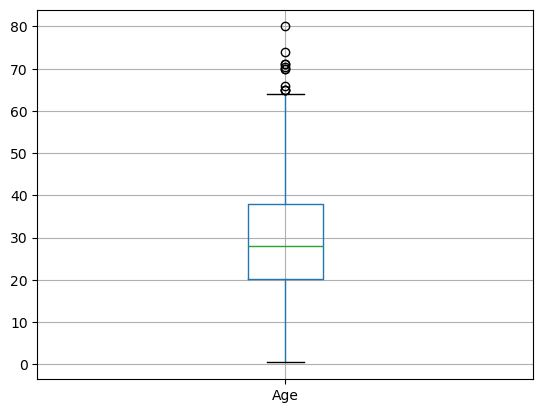

In [17]:
titanic[['Age']].boxplot();  # Visualize boxplots

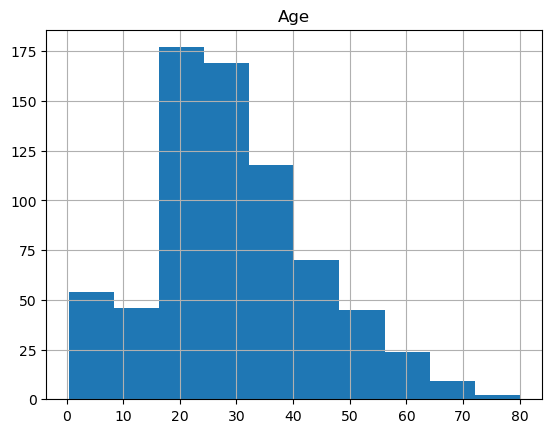

In [18]:
titanic[['Age']].hist();  # Visualize histograms

In [19]:
# Also remember to explore with .describe .info pd.plotting etc.

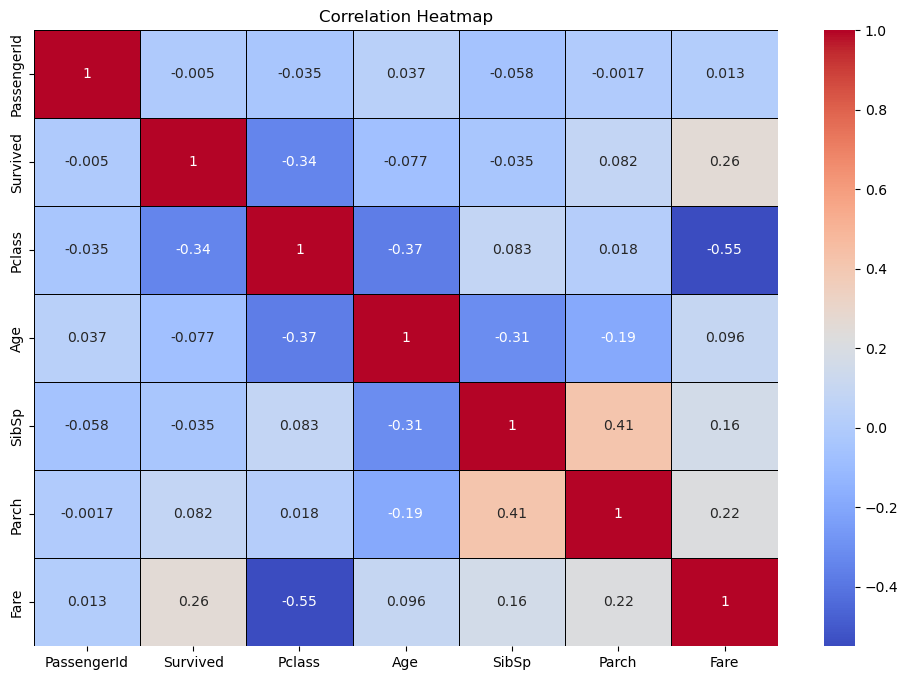

In [20]:
import seaborn as sns

corr_matrix = titanic.corr(numeric_only=True) # inspect correlations with the output variable and among the input features

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()



In [21]:
titanic.corr(numeric_only=True)['Survived'] # when only interested in correlations with Survived

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

### Check for Duplicates

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html

In [23]:
titanic.duplicated().sum()

0

### Check for Missing Values

In [25]:
# Are there any missing values?
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

`Cabin`, `Age` and `Embarked` have missing values, `Cabin` even predominantly so, we will just not use it. For `Age` we will try imputation, and as `Embarked` has only 2 cases of missing values, we will remove the rows that contain them. See below. `PassengerId`, `Name`, `Ticket` (contains no useful info) will not be used.

### 2. Set Up Train and Test Partitions
#### Train-test insensitive preprocessing

In [28]:
# For clarity we start here from scratch again to have all data manipulations together

titanic = pd.read_csv("data/titanic.csv")
titanic.shape

(891, 12)

In [29]:
# Convert categorical columns 'Sex' and 'Embarked' to numeric values
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})

# Use categorical encoding for 'Embarked'
titanic['Embarked'] = titanic['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Drop rows with missing values in 'Embarked', and irrelevant columns
titanic.dropna(subset=['Embarked'], inplace=True)
titanic.drop(columns=['Cabin', 'PassengerId', 'Name', 'Ticket'], inplace=True)

# Display the shape of the cleaned dataset
titanic.shape

(889, 8)

In [30]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0.0
1,1,1,1,38.0,1,0,71.2833,1.0
2,1,3,1,26.0,0,0,7.9250,0.0
3,1,1,1,35.0,1,0,53.1000,0.0
4,0,3,0,35.0,0,0,8.0500,0.0


In [31]:
# We dump the preprocessed dataset at this point for future use
titanic.to_csv("data/titanic_processed.csv", index=False)

In [32]:
# Let's define our X and y
y = titanic.Survived
X = titanic.drop(columns=['Survived'])
X.shape, y.shape

((889, 7), (889,))

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((711, 7), (178, 7), (711,), (178,))

We conceptually lock away the test data (X_test and y_test) and will return only to it to test our final model. A simple way of thinking about this: train data is the past, you can do whatever you want with it; test data represents the future, and you can't use the future to make your model, only the past.

#### Train-test sensitive preprocessing

#### Imputing Missing Values

In [36]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
708,1,1,22.0,0,0,151.5500,0.0
240,3,1,NaN,1,0,14.4542,1.0
382,3,0,32.0,0,0,7.9250,0.0
792,3,1,NaN,8,2,69.5500,0.0
683,3,0,14.0,5,2,46.9000,0.0


In [37]:
# As the algorithm will protest on missing values we have to fix this first for the Age missing values
titanic.Age.isnull().sum()

177

What can we do about the missing values? 

There are basically two ways to handle this:
- Throw out those rows or columns which have missing values (as with Cabin and Embarked)

Or: we can *guess* values for the missing values. 

- Take the mean or median of the values for that feature (univariate, simple imputer)
- Take into account features correlated with age to guess the value (multivariate, e.g. knn imputer). In this case, the samples most similar to the rest of the numeric feature values for a row with a missing value will be used to extrapolate from.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [39]:
from sklearn.impute import KNNImputer

In [40]:
imp = KNNImputer()
imp.get_params()

{'add_indicator': False,
 'copy': True,
 'keep_empty_features': False,
 'metric': 'nan_euclidean',
 'missing_values': nan,
 'n_neighbors': 5,
 'weights': 'uniform'}

In [41]:
imp.fit(X_train) # We use only the information in train to fit the model
X_train = imp.transform(X_train) # apply to train
X_test = imp.transform(X_test) # apply to test

In [42]:
X_train[:5] # 26.6 and 26.8 have been imputed

array([[  1.    ,   1.    ,  22.    ,   0.    ,   0.    , 151.55  ,
          0.    ],
       [  3.    ,   1.    ,  26.6   ,   1.    ,   0.    ,  14.4542,
          1.    ],
       [  3.    ,   0.    ,  32.    ,   0.    ,   0.    ,   7.925 ,
          0.    ],
       [  3.    ,   1.    ,  26.8   ,   8.    ,   2.    ,  69.55  ,
          0.    ],
       [  3.    ,   0.    ,  14.    ,   5.    ,   2.    ,  46.9   ,
          0.    ]])

#### Scaling Numeric Values

If different features have different ranges of values, there will be an implicit weighting of features that may not be appropriate. E.g. The `Age` and `Fare` features with their large values compared to the other features, could have more weight in the computation than they deserve. 

In the minmaxscaler (normalization) values are shifted and rescaled so that they end up ranging between 0 to 1. We do this by subtracting the min value and dividing by the max minus the min.

The standardscaler (standardization) transforms the values of each feature to a scaled version (z-score: the value minus the mean divided by the sd: this gives us comparable distributions of values for all features with mean 0 and sd 1).

We have to do this before we start experimenting but *after* splitting the data into train and test because otherwise we can **leak** information from test to train.

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Also try MinMaxScaler!

In [47]:
X_train[:5]

array([[-1.58410418,  1.40530972, -0.59236848, -0.47451561, -0.4756437 ,
         2.43059683, -0.57163833],
       [ 0.8122747 ,  1.40530972, -0.2558813 ,  0.38178033, -0.4756437 ,
        -0.35813533,  0.97963973],
       [ 0.8122747 , -0.71158691,  0.13912541, -0.47451561, -0.4756437 ,
        -0.49094895, -0.57163833],
       [ 0.8122747 ,  1.40530972, -0.24125142,  6.37585187,  2.01099358,
         0.76259506, -0.57163833],
       [ 0.8122747 , -0.71158691, -1.1775636 ,  3.80696406,  2.01099358,
         0.30186043, -0.57163833]])

### 3. Model Construction

In [49]:
# Machine Learning algorithm to be used is logistic regression (binary class Survived to be predicted)
from sklearn.linear_model import LogisticRegression  

We start with simplest possible experiment. We use all the default settings of the Logistic Regression implementation and fit a model to our X_train and X_test

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [52]:
logreg = LogisticRegression(random_state=42) # random state added to make sure that the experiment is replicable

In [53]:
logreg.get_params() # These are the default settings

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

- C: Inverse of regularization strength; smaller values specify stronger regularization.
- fit_intercept: Whether to include an intercept in the model.
- penalty: Specifies regularization type ('l1', 'l2', 'elasticnet').
- solver: Algorithm used for optimization ('lbfgs' is a common choice).


In [55]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [56]:
logreg.coef_

array([[-1.05364193,  1.2482838 , -0.64235427, -0.47246577, -0.04850961,
         0.06374837,  0.16420026]])

### 4. Model Evaluation

In [58]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [59]:
y_test_pred = logreg.predict(X_test) # predict output for the test data

In [60]:
y_test.values

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1])

In [61]:
y_test_pred

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1])

In [62]:
y_test_pred_probs = logreg.predict_proba(X_test) # predict output for the test data

In [63]:
y_test_pred_probs[:5]

array([[0.90006311, 0.09993689],
       [0.03741525, 0.96258475],
       [0.27749253, 0.72250747],
       [0.73551107, 0.26448893],
       [0.03192748, 0.96807252]])

In [64]:
print(classification_report(y_test, y_test_pred)) # evaluate how well the model did

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       109
           1       0.71      0.80      0.75        69

    accuracy                           0.80       178
   macro avg       0.79      0.80      0.79       178
weighted avg       0.80      0.80      0.80       178



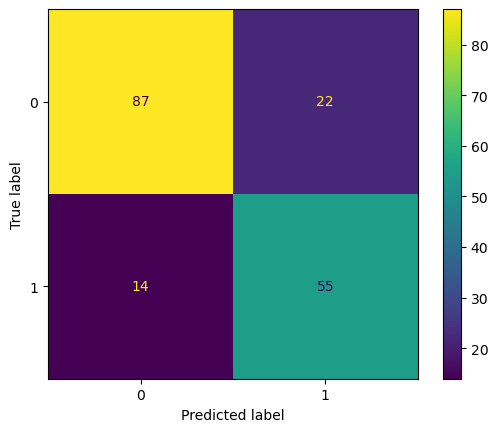

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

<img src="figures/ml_flow.png">